In [32]:
!pip install kaggle


In [33]:
from google.colab import files

# Upload the kaggle.json file that you downloaded
uploaded = files.upload()

Saving kaggle.json to kaggle (1).json


In [34]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

!kaggle competitions download -c cassava-leaf-disease-classification
import zipfile

with zipfile.ZipFile('cassava-leaf-disease-classification.zip', 'r') as zip_ref:
    zip_ref.extractall('H')

cassava-leaf-disease-classification.zip: Skipping, found more recently modified local copy (use --force to force download)


In [35]:
import os
print(os.listdir('H'))

['train_tfrecords', 'sample_submission.csv', 'test_tfrecords', 'train.csv', 'label_num_to_disease_map.json', 'train_images', 'test_images']


# Cassava Leaf Disease Multi-class Classification Using Deep Learning




1. GitHub URL: https://github.com/XieXiao94/5511-Cassava-Leaf-Disease-Multi-Class-Classifcation-Using-Deep-Learning/blob/main/Cassava_Leaf_Disease_Multi_Class_Classification_Using_Deep_Learning.ipynb

2. About this project:

    This project will study 21K images of cassava leaves with the corresponding disease classes. The goal is to build a model to predict the cassava leaf disease classification. There are five disease classes. class 0: Cassava Bacterial Blight disease, class 1: Cassava Brown Streak Disease, class 2: Cassava Green Mottle disease, class 3: Cassava Mosaic Disease disease, class 4: Healthy. The type of learning is deep learning and the type of task is multi-class image classification.

    The deep learning models that will be used are CNN and vgg16.

    CNN is a convolution neural network that utilizes neural networks to learn features or patterns from images for recognition and classification.

    VGG16 is a deeper formate of the CNN model. It has 16 layers.

3. Data Source:

  The dataset is from a Kaggle project named ' Cassava Leaf Disease Classification'.

4. Citation:

  Cassava leaf disease classification. (n.d.). Kaggle. https://www.kaggle.com/competitions/cassava-leaf-disease-classification/overview

5. Dataset:
  
  The dataset contains train images, test images and train_labels.csv. The train and test images are cassava plant images. The train image has 21K+ images and the test image has 1 image. All images are in 800 x 600 dimensions, stored in a directory structure with a .jpg extension.

  The train_labels.csv corresponds with the train image. It is tabulated data and has a data size of 21K rows and 2 columns. Each row is an image and the 2 columns are the image id and labels of the image.

6. Motivation:

 For my week 3 assignment where I work on cancer detection using deep learning for binary class classification. It was my first time working with images and I learned a lot from that project. For my final project, I want to work with images again but more advanced. This project is multi-class image classification, which I think is interesting.

In [36]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import glob
from PIL import Image
import os
import cv2
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout,BatchNormalization, Activation, GlobalAveragePooling2D
from tensorflow.keras import models, layers
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.optimizers import Adam
from keras.models import Model
from tensorflow.keras.applications import VGG16
import tensorflow as tf
from tensorflow import keras
# from kerastuner.tuners import RandomSearch

# Load Datasets

In [37]:
import json

with open('H/label_num_to_disease_map.json', 'r') as file:
    labels = json.load(file)

labels

{'0': 'Cassava Bacterial Blight (CBB)',
 '1': 'Cassava Brown Streak Disease (CBSD)',
 '2': 'Cassava Green Mottle (CGM)',
 '3': 'Cassava Mosaic Disease (CMD)',
 '4': 'Healthy'}

In [38]:
train_labels = pd.read_csv('H/train.csv')
train_labels

,image_id,label
0,1000015157.jpg,0
1,1000201771.jpg,3
2,100042118.jpg,1
3,1000723321.jpg,1
4,1000812911.jpg,3
...,...,...
21392,999068805.jpg,3
21393,999329392.jpg,3
21394,999474432.jpg,1
21395,999616605.jpg,4


In [39]:
train_dir = 'H/train_images/'
test_dir =  'H/test_images/'

# EDA

1. Check the dataset size
2.Distribution of Labels
3. Visualization of Each Class
4. RBG Analysis of Each Class
5. Correlation of Disease Classes

In [ ]:
train_imglen = len(glob.glob(f'{train_dir}/*.jpg'))
test_imglen = len(glob.glob(f'{test_dir}/*.jpg'))

print(f'Train Images has {train_imglen} images')
print(f'Test Images has {test_imglen} image')

Train Images has 21397 images
Test Images has 1 image


Text(0, 0.5, 'Count')

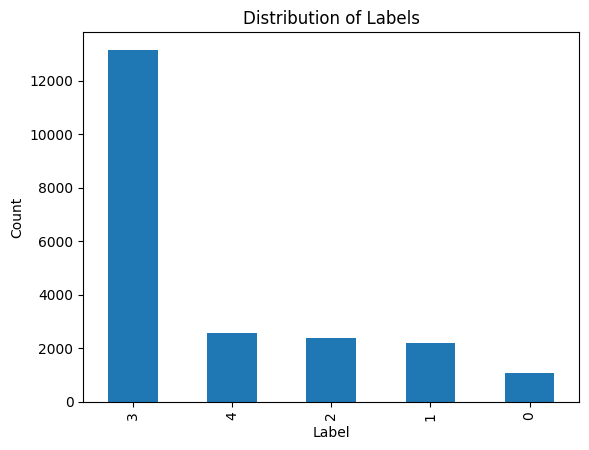

In [ ]:
train_labels['label'].value_counts().plot(kind='bar')
plt.title('Distribution of Labels')
plt.xlabel('Label')
plt.ylabel('Count')

In [ ]:
train_labels['label'].value_counts()

,count
label,
3,13158
4,2577
2,2386
1,2189
0,1087




0: Cassava Bacterial Blight (CBB)


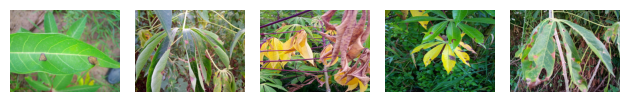



1: Cassava Brown Streak Disease (CBSD)


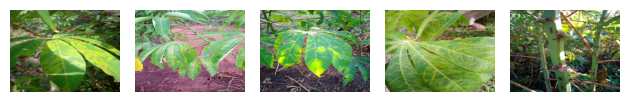



2: Cassava Green Mottle (CGM)


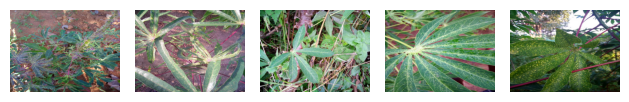



3: Cassava Mosaic Disease (CMD)


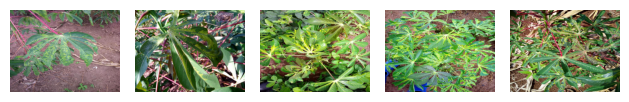



4: Healthy


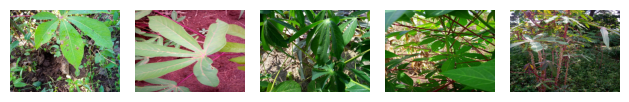

In [40]:
# Visualization of Each Class
for j in range(5):
    images = train_labels[train_labels['label']==j].sample(10)['image_id'].values
    print('\n')
    print(f'{j}: {labels[str(j)]}')

    for i, image_id in enumerate(images[:5]):
        img_path = os.path.join(train_dir,image_id )
        img = Image.open(img_path)
        plt.subplot(2,5,i+1)
        plt.imshow(img)
        plt.axis('off')


    plt.tight_layout()
    plt.show()

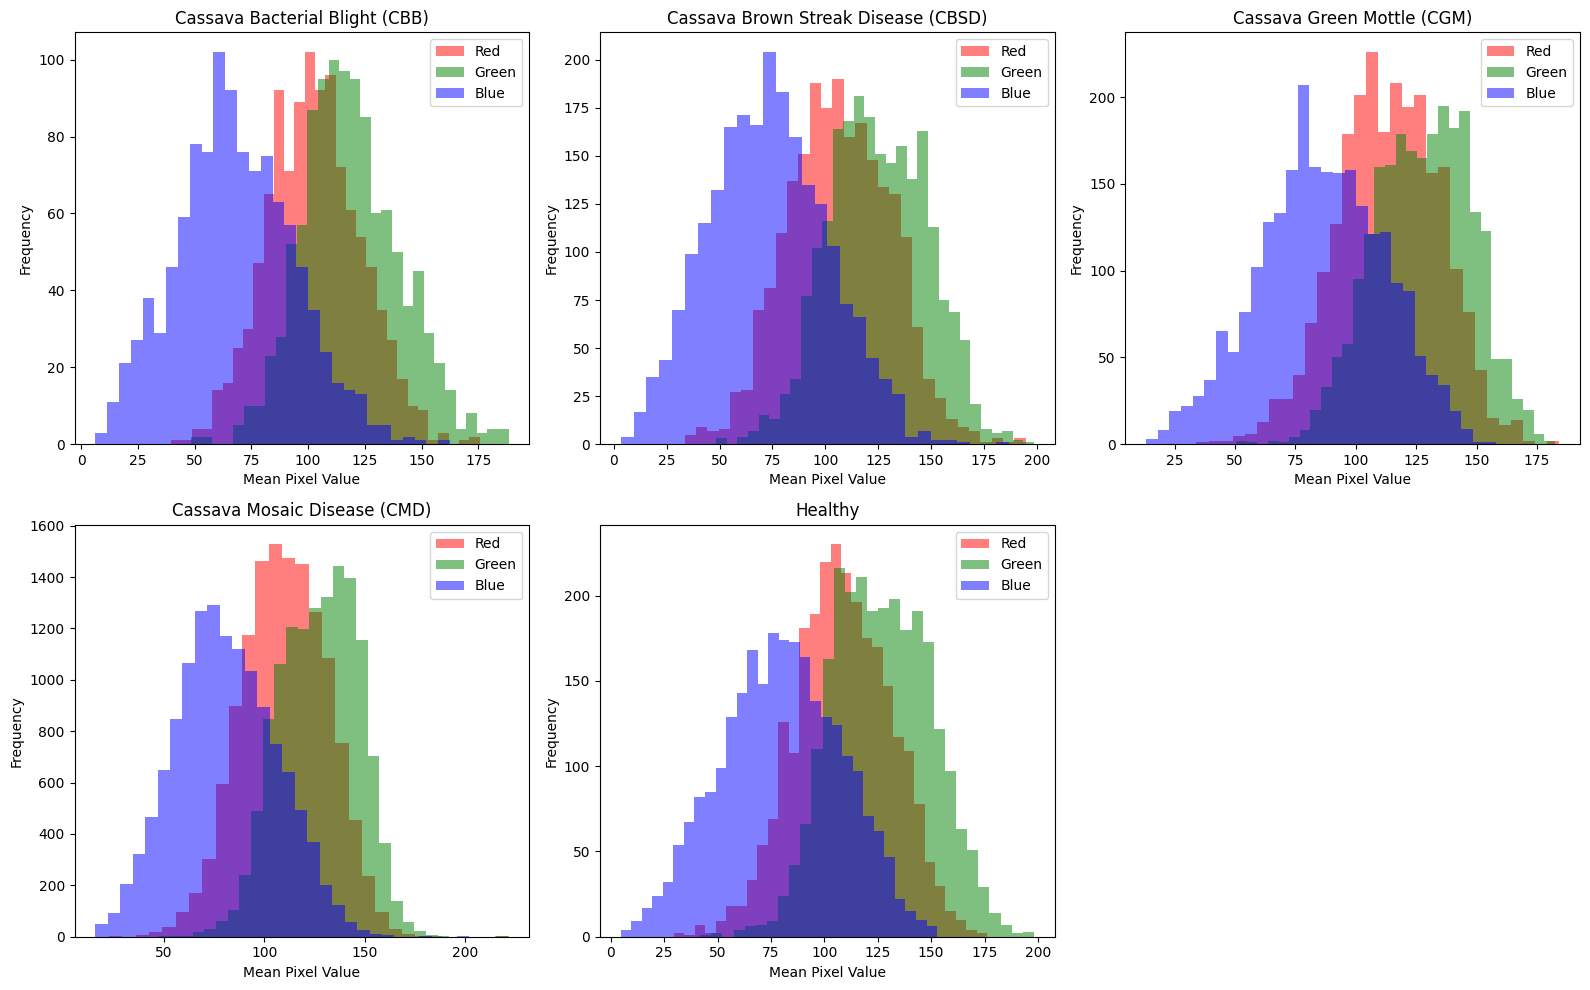

In [ ]:
# RGB Analysis of Each Class

image_by_class= {0: [], 1: [], 2: [], 3: [], 4: []}

for _, row in train_labels.iterrows():
    image_id = row['image_id']
    label = row['label']
    image_by_class[label].append(os.path.join(train_dir, image_id))

def color_analyst(image_paths):
    red, green, blue = [], [], []

    for image_path in image_paths:
        image = np.array(Image.open(image_path).resize((128, 128)))
        red.append(np.mean(image[:, :, 0]))
        green.append(np.mean(image[:, :, 1]))
        blue.append(np.mean(image[:, :, 2]))

    return red, green, blue

plt.figure(figsize=(16, 10))

for disease, image_paths in image_by_class.items():
    red, green, blue = color_analyst(image_paths)

    plt.subplot(2, 3, disease + 1)
    plt.hist(red, bins=30, color='red', alpha=0.5, label='Red')
    plt.hist(green, bins=30, color='green', alpha=0.5, label='Green')
    plt.hist(blue, bins=30, color='blue', alpha=0.5, label='Blue')
    plt.title(f'{labels[str(disease)]}')
    plt.xlabel('Mean Pixel Value')
    plt.ylabel('Frequency')
    plt.legend()

plt.tight_layout()
plt.show()

### Finding  - RGB Analysis of Each Class:

CBB disease: Widespread of red and green but a low spread of blue, indicating blotches on the leaves

CBSD disease: Widespread of red and green, indicating yellow dotting or yellowing of the leaves

CGM disease: Widespread red indicating green  mottled leaves

CMD disease: Widespread of all colours indicating mosaic pattern on the leaves

Healthy: balanced distribution of all colours.

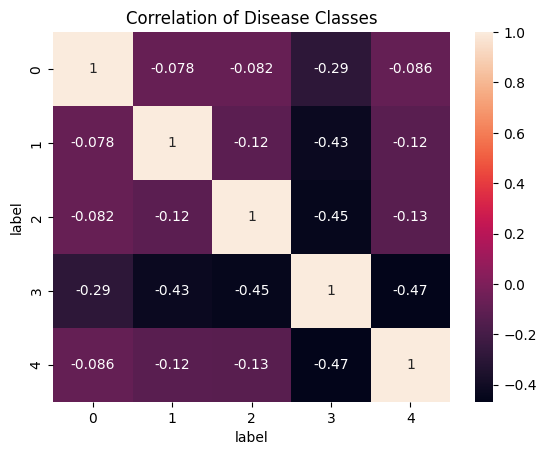

In [ ]:
# Correlation of Disease Classes
Comorbid_diseases = pd.crosstab(train_labels['image_id'], train_labels['label'])
sns.heatmap(Comorbid_diseases.corr(), annot=True)
plt.title('Correlation of Disease Classes')
plt.show()

### Finding - correlation of disease classes
The results show the correlation of the classes are all negative. It means when a plant has one disease, the chance they have another disease is really low.

# Preprocessing

1. Check null value
2. Check outliers for train directories and remove outliers

  a. duplicates

  b. small or large images

  c. blank images

  d. blurry images

  e. low_resolution_image


3. Check the filenames for train_label and train directories

4. Convert labels from integers to strings

5. Split the dataset to train and validation dataset

6. Data augmentation

  Using Imagedatagenerator for faster and easier transformation, normalizing and preprocessing of the dataset

In [ ]:
# Check null value

train_labels.isnull().sum()


image_id    0
label       0
dtype: int64

In [ ]:
# duplicates

duplicates = train_labels['image_id'].duplicated().sum()
print(f'Duplicate Images: {duplicates}')

Duplicate Images: 0


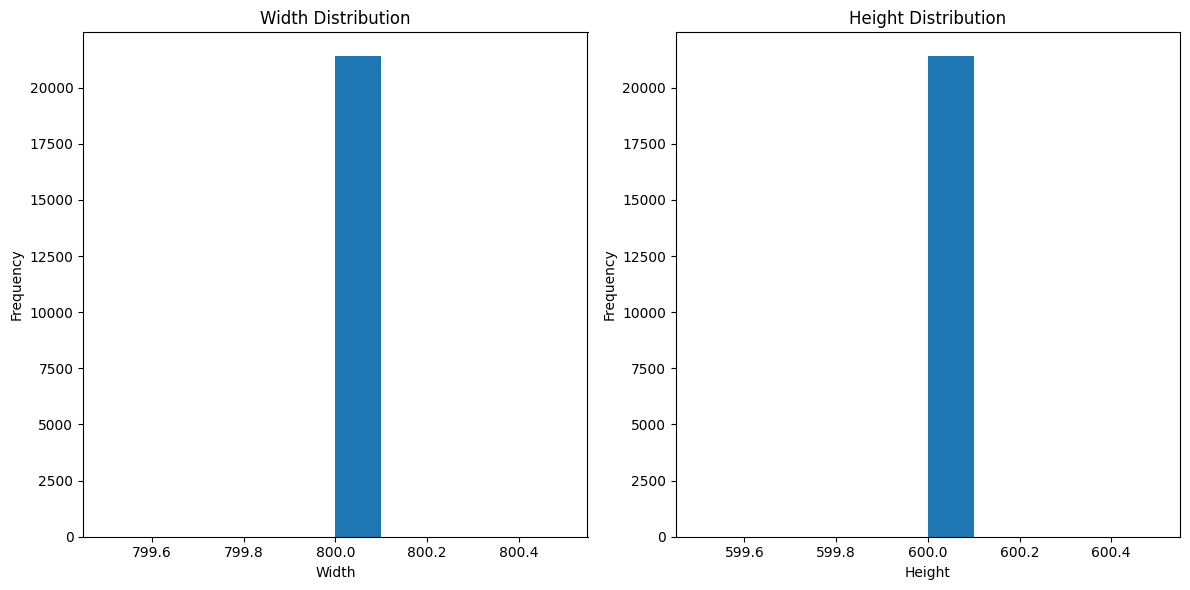

In [ ]:
# check the distribution of all the image to identify small or large images(outliers)

image_dims = [Image.open(os.path.join(train_dir, image_id)).size for image_id in train_labels['image_id']]
widths, heights = zip(*image_dims)

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.hist(widths)
plt.title('Width Distribution')
plt.xlabel('Width')
plt.ylabel('Frequency')

plt.subplot(1, 2, 2)
plt.hist(heights)
plt.title('Height Distribution')
plt.xlabel('Height')
plt.ylabel('Frequency')

plt.tight_layout()
plt.show()

In [ ]:
# Outliers: Blank, Blurry and Low Resolution Images

low_res_images = []
blurry_images = []
blank_images = []

def blank_image(img, threshold=10):
    img_array = np.array(img)
    return np.all(img_array < threshold) or np.all(img_array > 255 - threshold)

def blurry_image(img, threshold=100.0):
    img_array = np.array(img)
    laplacian_var = cv2.Laplacian(img_array, cv2.CV_64F).var()
    return laplacian_var < threshold

def low_resolution_image(img, min_width=224, min_height=224):
    width, height = img.size
    return width < min_width or height < min_height


for filename in os.listdir(train_dir):
    image_path = os.path.join(train_dir, filename)
    img = Image.open(image_path).convert('L')

    if low_resolution_image(img, min_width=224, min_height=224):
        low_res_images.append(filename)

    if blank_image(img, 10):
        blank_images.append(filename)

    if blurry_image(img, 100):
        blurry_images.append(filename)

print('blank images:', len(blank_images))
print('blurry images:', len(blurry_images))
print('low-resolution images:', len(low_res_images))


blank images: 0
blurry images: 397
low-resolution images: 0


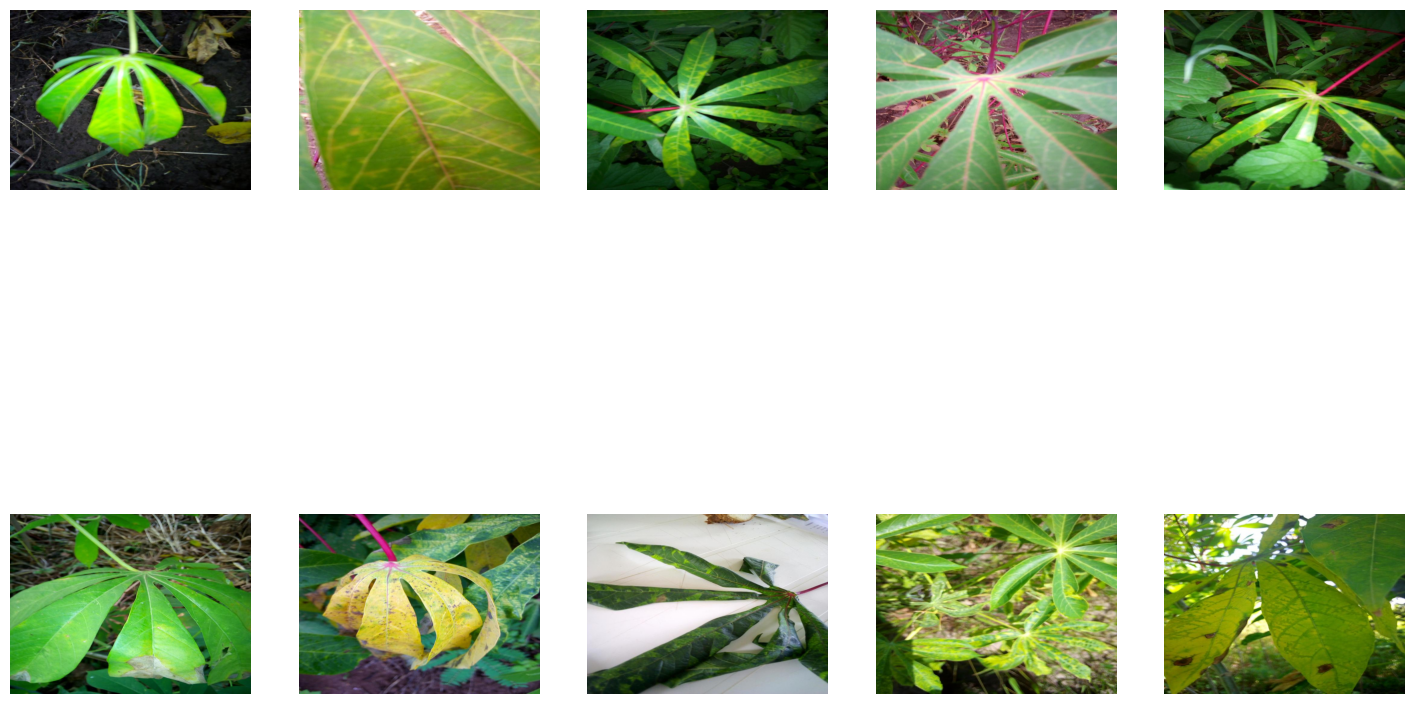

In [ ]:
# Visualization of blurry images

plt.figure(figsize=(18, 12))

for i, id in enumerate(blurry_images[:10]):
    image_path = os.path.join(train_dir, id)
    image = Image.open(image_path)
    plt.subplot(2,5,i+1)
    plt.imshow(image)

In [ ]:
# remove outliers from train_labels dataset

train_labels = train_labels[~train_labels['image_id'].isin(blurry_images)]

In [ ]:
#  filenames

print("id in the train_label:", "\n",train_labels['image_id'].head())

print("\nid in the images:","\n", os.listdir(train_dir)[:5])

id in the train_label: 
 0    1000015157.jpg
1    1000201771.jpg
2     100042118.jpg
3    1000723321.jpg
4    1000812911.jpg
Name: image_id, dtype: object

id in the images: 
 ['1235188286.jpg', '1215607589.jpg', '478554372.jpg', '2763304605.jpg', '2826122413.jpg']


In [ ]:
train_labels.info()

<class 'pandas.core.frame.DataFrame'>
Index: 21000 entries, 0 to 21396
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   image_id  21000 non-null  object
 1   label     21000 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 492.2+ KB


In [ ]:
# convert label from integers to strings,
# b/c flow_from_dataframe expects string format

train_labels['label'] = train_labels['label'].astype(str)


/tmp/ipykernel_23/3917693869.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_labels['label'] = train_labels['label'].astype(str)


In [ ]:
#split the dataset

train_labels, val_labels = train_test_split(train_labels, test_size=0.2, random_state=42)
print(train_labels.shape)
print(val_labels.shape)

(16800, 2)
(4200, 2)


In [ ]:
# Data augmentation
# To increase the model's robustness, we apply normalization to the dataset to range [0,1]
# and generate different types of images based on the original images,
# such as slightly rotated images, shift width and height slightly and zoomed-in images.

image_size = 96
batch_size = 64

train_datagen = ImageDataGenerator(
    rescale=1.0/255.0,
    rotation_range=20,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.1,
    fill_mode='nearest'
)

val_datagen = ImageDataGenerator(rescale=1.0/255.0)

In [ ]:

train_generator = train_datagen.flow_from_dataframe(
    dataframe=train_labels,
    directory=train_dir,
    x_col='image_id',
    y_col='label',
    target_size=(image_size, image_size),
    batch_size=batch_size,
    class_mode='categorical'
)

Found 16800 validated image filenames belonging to 5 classes.


In [ ]:
val_generator = val_datagen.flow_from_dataframe(
    dataframe=val_labels,
    directory=train_dir,
    x_col='image_id',
    y_col='label',
    target_size=(image_size, image_size),
    batch_size=batch_size,
    class_mode='categorical' ,
    shuffle = False
)

Found 4200 validated image filenames belonging to 5 classes.


# Build Models

For models, I plan to try different models starting from easy to complex models. Perform comparisons of their accuracy, loss and validation accuracy and loss.

Basic CNN Model: I will start with a basic CNN model, as it is easy to build and can be customized with different parameters based on the complexity of the dataset such as layers, pooling, and strides to avoid overfitting.

1. CNN Model with Relu Activation: Relu output is [0, infinity). It is simple and effective for small datasets and helps prevent vanishing gradient issues.

2. CNN Model with Swish Activation: Swish output is (-infinity, infinity) and it has smooth gradient flow. So It works well to capture the underlying features and separate the label better.

VGG16 Model: I would like to try with VGG16 model. It is deeper model with 16 layers. It can capture complex patterns from the dataset and achieve higher accuracy. It supports transfer learning with pre-trained weights that can reduce computation costs.


### Model 1 - CNN model with relu activation

In [ ]:

cnn_model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(image_size, image_size, 3)),
    MaxPooling2D(pool_size=(2, 2)),

    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),

    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),

    Conv2D(256, (3, 3), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),

    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(5, activation='softmax')
])

cnn_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

/opt/conda/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [ ]:
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
model_checkpoint = ModelCheckpoint('cnn_best_model.keras', monitor='val_loss', save_best_only=True)

cnn = cnn_model.fit(train_generator, epochs=10, validation_data=val_generator, callbacks=[early_stopping, model_checkpoint])

Epoch 1/10


/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()
I0000 00:00:1728974468.249237      67 service.cc:145] XLA service 0x7c712000bd70 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1728974468.249299      67 service.cc:153]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0


  1/263 ━━━━━━━━━━━━━━━━━━━━ 41:09 9s/step - accuracy: 0.0938 - loss: 1.6337

I0000 00:00:1728974472.843886      67 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


263/263 ━━━━━━━━━━━━━━━━━━━━ 131s 465ms/step - accuracy: 0.6171 - loss: 1.1755 - val_accuracy: 0.6507 - val_loss: 0.9943
Epoch 2/10
263/263 ━━━━━━━━━━━━━━━━━━━━ 122s 453ms/step - accuracy: 0.6320 - loss: 1.0519 - val_accuracy: 0.6448 - val_loss: 1.0179
Epoch 3/10
263/263 ━━━━━━━━━━━━━━━━━━━━ 122s 455ms/step - accuracy: 0.6430 - loss: 0.9960 - val_accuracy: 0.6448 - val_loss: 0.9490
Epoch 4/10
263/263 ━━━━━━━━━━━━━━━━━━━━ 140s 449ms/step - accuracy: 0.6581 - loss: 0.9399 - val_accuracy: 0.6750 - val_loss: 0.8900
Epoch 5/10
263/263 ━━━━━━━━━━━━━━━━━━━━ 124s 460ms/step - accuracy: 0.6632 - loss: 0.9155 - val_accuracy: 0.6571 - val_loss: 0.9402
Epoch 6/10
263/263 ━━━━━━━━━━━━━━━━━━━━ 121s 449ms/step - accuracy: 0.6792 - loss: 0.8746 - val_accuracy: 0.6776 - val_loss: 0.8432
Epoch 7/10
263/263 ━━━━━━━━━━━━━━━━━━━━ 121s 451ms/step - accuracy: 0.6788 - loss: 0.8535 - val_accuracy: 0.6929 - val_loss: 0.8103
Epoch 8/10
263/263 ━━━━━━━━━━━━━━━━━━━━ 119s 443ms/step - accuracy: 0.6785 - loss: 0.84

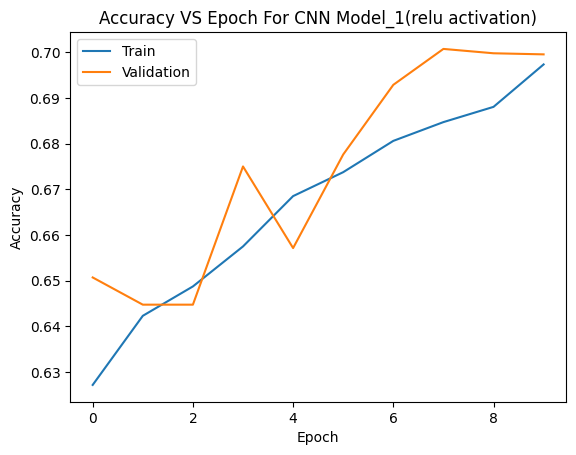

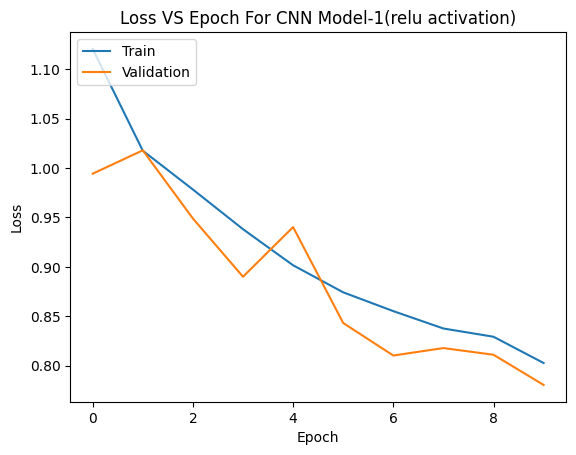

In [ ]:
plt.plot(cnn.history['accuracy'])
plt.plot(cnn.history['val_accuracy'])
plt.title('Accuracy VS Epoch For CNN Model_1(relu activation)')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

plt.plot(cnn.history['loss'])
plt.plot(cnn.history['val_loss'])
plt.title('Loss VS Epoch For CNN Model-1(relu activation)')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

### Model 2 - CNN Model with Swish Activation and BatchNormalization

In [ ]:

cnn_model2= models.Sequential([
    Conv2D(32, (3, 3), strides=(1, 1), input_shape=(image_size, image_size, 3)),
    BatchNormalization(),
    Activation('swish'),
    MaxPooling2D(pool_size=(2, 2)),

    Conv2D(64, (3, 3), strides=(1, 1)),
    BatchNormalization(),
    Activation('swish'),
    MaxPooling2D(pool_size=(2, 2)),

    Conv2D(128, (3, 3), strides=(1, 1)),
    BatchNormalization(),
    Activation('swish'),
    MaxPooling2D(pool_size=(2, 2)),

    Conv2D(256, (3, 3), strides=(1, 1)),
    BatchNormalization(),
    Activation('swish'),
    MaxPooling2D(pool_size=(2, 2)),

    Flatten(),
    Dense(512, activation='swish'),
    Dropout(0.5),
    Dense(5, activation='softmax')
])


In [ ]:
cnn_model2.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
model_checkpoint = ModelCheckpoint('cnn_best_model.keras', monitor='val_loss', save_best_only=True)

cnn2 = cnn_model2.fit(train_generator, epochs=10, validation_data=val_generator, callbacks=[early_stopping, model_checkpoint])


Epoch 1/10
263/263 ━━━━━━━━━━━━━━━━━━━━ 132s 466ms/step - accuracy: 0.5620 - loss: 1.7440 - val_accuracy: 0.1083 - val_loss: 1.7581
Epoch 2/10
263/263 ━━━━━━━━━━━━━━━━━━━━ 120s 445ms/step - accuracy: 0.6318 - loss: 1.0119 - val_accuracy: 0.5517 - val_loss: 1.1606
Epoch 3/10
263/263 ━━━━━━━━━━━━━━━━━━━━ 128s 474ms/step - accuracy: 0.6570 - loss: 0.9277 - val_accuracy: 0.5800 - val_loss: 1.1135
Epoch 4/10
263/263 ━━━━━━━━━━━━━━━━━━━━ 125s 464ms/step - accuracy: 0.6590 - loss: 0.8929 - val_accuracy: 0.6345 - val_loss: 0.9841
Epoch 5/10
263/263 ━━━━━━━━━━━━━━━━━━━━ 121s 449ms/step - accuracy: 0.6823 - loss: 0.8618 - val_accuracy: 0.5693 - val_loss: 1.0815
Epoch 6/10
263/263 ━━━━━━━━━━━━━━━━━━━━ 140s 444ms/step - accuracy: 0.6850 - loss: 0.8185 - val_accuracy: 0.5331 - val_loss: 1.2125
Epoch 7/10
263/263 ━━━━━━━━━━━━━━━━━━━━ 120s 447ms/step - accuracy: 0.6912 - loss: 0.8126 - val_accuracy: 0.4962 - val_loss: 1.2053
Epoch 8/10
263/263 ━━━━━━━━━━━━━━━━━━━━ 120s 446ms/step - accuracy: 0.6953 -

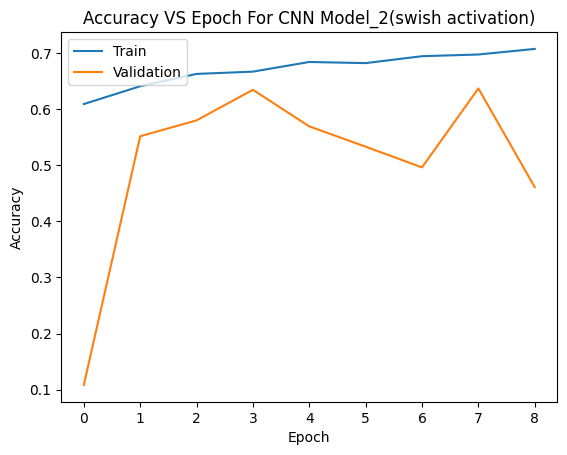

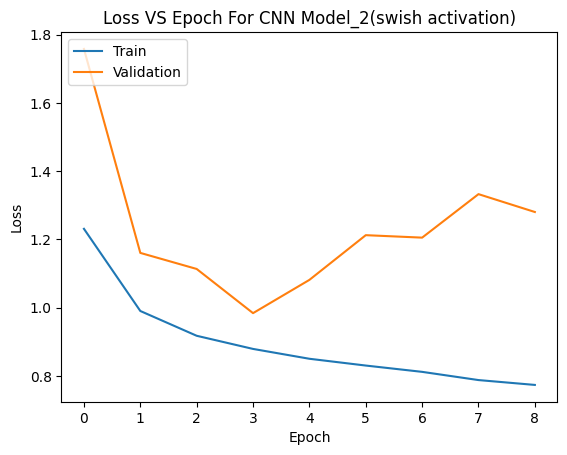

In [ ]:
plt.plot(cnn2.history['accuracy'])
plt.plot(cnn2.history['val_accuracy'])
plt.title('Accuracy VS Epoch For CNN Model_2(swish activation)')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

plt.plot(cnn2.history['loss'])
plt.plot(cnn2.history['val_loss'])
plt.title('Loss VS Epoch For CNN Model_2(swish activation)')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

### Model 3 - VGG16 Model

In [ ]:
vgg_base_model = VGG16(weights='imagenet', include_top=False, input_shape=(image_size, image_size, 3))
x =vgg_base_model.output
x = Flatten()(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.5)(x)
predictions = Dense(5, activation='softmax')(x)

vgg16_model = Model(inputs=vgg_base_model.input, outputs=predictions)

for layer in vgg_base_model.layers:
    layer.trainable = False

vgg16_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step


In [ ]:
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
model_checkpoint = ModelCheckpoint('vgg_best_model.keras', monitor='val_loss', save_best_only=True)

vgg16 = vgg16_model.fit(train_generator, epochs=10, validation_data=val_generator, callbacks=[early_stopping, model_checkpoint])

Epoch 1/10
263/263 ━━━━━━━━━━━━━━━━━━━━ 135s 480ms/step - accuracy: 0.6098 - loss: 1.1982 - val_accuracy: 0.6586 - val_loss: 0.9530
Epoch 2/10
263/263 ━━━━━━━━━━━━━━━━━━━━ 125s 465ms/step - accuracy: 0.6491 - loss: 0.9956 - val_accuracy: 0.6600 - val_loss: 0.9250
Epoch 3/10
263/263 ━━━━━━━━━━━━━━━━━━━━ 122s 453ms/step - accuracy: 0.6504 - loss: 0.9829 - val_accuracy: 0.6610 - val_loss: 0.9348
Epoch 4/10
263/263 ━━━━━━━━━━━━━━━━━━━━ 120s 447ms/step - accuracy: 0.6578 - loss: 0.9607 - val_accuracy: 0.6598 - val_loss: 0.9291
Epoch 5/10
263/263 ━━━━━━━━━━━━━━━━━━━━ 122s 455ms/step - accuracy: 0.6644 - loss: 0.9402 - val_accuracy: 0.6583 - val_loss: 0.9260
Epoch 6/10
263/263 ━━━━━━━━━━━━━━━━━━━━ 120s 445ms/step - accuracy: 0.6670 - loss: 0.9505 - val_accuracy: 0.6476 - val_loss: 0.9575
Epoch 7/10
263/263 ━━━━━━━━━━━━━━━━━━━━ 121s 450ms/step - accuracy: 0.6625 - loss: 0.9433 - val_accuracy: 0.6507 - val_loss: 0.9441


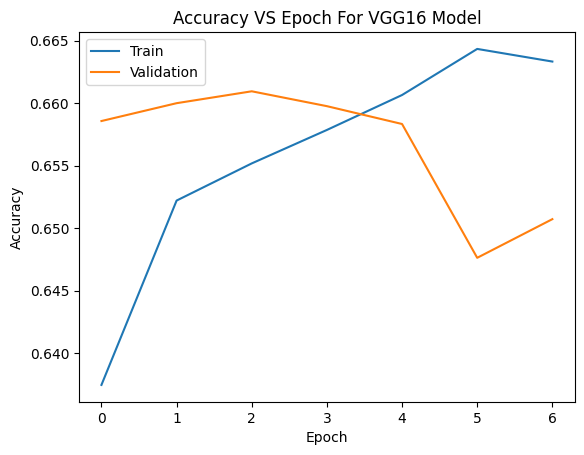

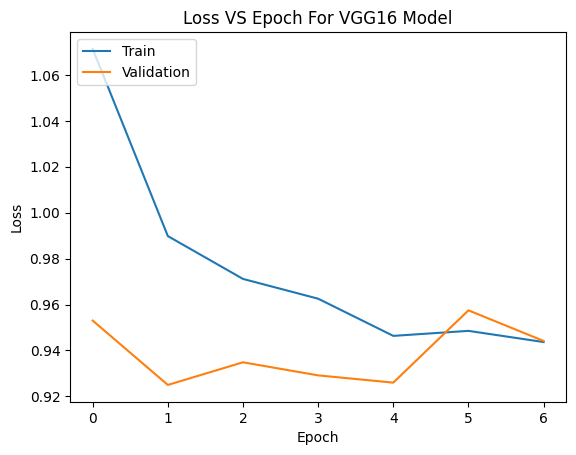

In [ ]:
plt.plot(vgg16.history['accuracy'])
plt.plot(vgg16.history['val_accuracy'])
plt.title('Accuracy VS Epoch For VGG16 Model')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

plt.plot(vgg16.history['loss'])
plt.plot(vgg16.history['val_loss'])
plt.title('Loss VS Epoch For VGG16 Model')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Summary Table Without Hyperparameter Tuning


In [ ]:
from tabulate import tabulate

cnn1_table = [0.6989, 0.8007, 0.6995, 0.7806]
cnn2_table = [0.7080, 0.7736, 0.4610, 1.2804]
VGG16_table = [0.6625, 0.9433, 0.6507, 0.9441]

data = [
    ['CNN 1'] + cnn1_table,
    ['CNN 2'] + cnn2_table,
    ['VGG16'] + VGG16_table,

]

headers = ['Models', 'Train data Accuracy', 'Train data Loss', 'Validation data Accuracy', 'Validation data Loss']

table = tabulate(data, headers=headers, tablefmt='grid')

print(table)

+----------+-----------------------+-------------------+----------------------------+------------------------+
| Models   |   Train data Accuracy |   Train data Loss |   Validation data Accuracy |   Validation data Loss |
+==========+=======================+===================+============================+========================+
| CNN 1    |                0.6989 |            0.8007 |                     0.6995 |                 0.7806 |
+----------+-----------------------+-------------------+----------------------------+------------------------+
| CNN 2    |                0.708  |            0.7736 |                     0.461  |                 1.2804 |
+----------+-----------------------+-------------------+----------------------------+------------------------+
| VGG16    |                0.6625 |            0.9433 |                     0.6507 |                 0.9441 |
+----------+-----------------------+-------------------+----------------------------+------------------------+


# Hyperparameter Tuning - CNN Model 1 with relu activation

CNN Model 1: Validation accuracy is higher than training accuracy.

CNN Model 2: Slightly better accuracy than CNN Model 1, but suffers from an overfitting issue.

This project is evaluated on validation accuracy. So I choose CNN Model 1 with relu activation for hyperparameter tuning.



In [ ]:

def cnn_hyper(hp):
    model = keras.Sequential([
        layers.Conv2D(32, (3, 3), activation='relu', strides=(1, 1), input_shape=(image_size, image_size, 3)),
        layers.MaxPooling2D(pool_size=(2, 2)),

        layers.Conv2D(64, (3, 3), activation='relu', strides=(1, 1)),
        layers.MaxPooling2D(pool_size=(2, 2)),

        layers.Conv2D(128, (3, 3), activation='relu', strides=(1, 1)),
        layers.MaxPooling2D(pool_size=(2, 2)),

        layers.Conv2D(256, (3, 3), activation='relu', strides=(1, 1)),
        layers.MaxPooling2D(pool_size=(2, 2)),

        layers.Flatten(),
        layers.Dense(hp.Int('dense_units', 256, 1024, step=256), activation='relu'),
        layers.Dropout(hp.Float('dropout', 0.2, 0.5, step=0.1)),
        layers.Dense(5, activation='softmax')
    ])

    model.compile(optimizer=keras.optimizers.Adam(hp.Float('learning_rate', 1e-4, 1e-1, sampling='LOG')),
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    return model

tuner = RandomSearch(
    cnn_hyper,
    objective='val_accuracy',
    max_trials=5,
    executions_per_trial=1,
    directory='my_dir',
    project_name='cnn_hyper_tuning'
)

early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
model_checkpoint = ModelCheckpoint('cnn_hyper_best_model.keras', monitor='val_loss', save_best_only=True)

tuner.search(train_generator,
             epochs=10, validation_data=val_generator,
             callbacks=[early_stopping, model_checkpoint])



Trial 5 Complete [00h 20m 13s]
val_accuracy: 0.7130952477455139

Best val_accuracy So Far: 0.7130952477455139
Total elapsed time: 01h 38m 34s


In [ ]:
best_model = tuner.get_best_models(num_models=1)[0]


/opt/conda/lib/python3.10/site-packages/keras/src/saving/saving_lib.py:415: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 26 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


In [ ]:
best_hypers = tuner.get_best_hyperparameters(num_trials=1)[0]

tuner.results_summary()

Results summary
Results in my_dir/cnn_hyper_tuning
Showing 10 best trials
Objective(name="val_accuracy", direction="max")

Trial 4 summary
Hyperparameters:
dense_units: 256
dropout: 0.30000000000000004
learning_rate: 0.0013887174154221847
Score: 0.7130952477455139

Trial 3 summary
Hyperparameters:
dense_units: 1024
dropout: 0.30000000000000004
learning_rate: 0.00035765348515623055
Score: 0.6935714483261108

Trial 1 summary
Hyperparameters:
dense_units: 512
dropout: 0.2
learning_rate: 0.0027076211876182277
Score: 0.6802380681037903

Trial 0 summary
Hyperparameters:
dense_units: 1024
dropout: 0.30000000000000004
learning_rate: 0.006522196136744222
Score: 0.6204761862754822

Trial 2 summary
Hyperparameters:
dense_units: 512
dropout: 0.30000000000000004
learning_rate: 0.010260144072139944
Score: 0.6204761862754822


In [ ]:

print(f"""
Best hyperparameters for CNN model are:
{best_hypers.get('dense_units')} units in the dense layer
{best_hypers.get('dropout')} dropout rate
{best_hypers.get('learning_rate')} learning rate for the optimizer
""")


Best hyperparameters for CNN model are:
256 units in the dense layer
0.30000000000000004 dropout rate
0.0013887174154221847 learning rate for the optimizer



In [ ]:

cnn_model_best = tuner.hypermodel.build(best_hypers)
cnn_best = cnn_model_best.fit(train_generator, epochs=20, validation_data = val_generator, callbacks=[early_stopping, model_checkpoint])


Epoch 1/20
263/263 ━━━━━━━━━━━━━━━━━━━━ 125s 451ms/step - accuracy: 0.6091 - loss: 1.1923 - val_accuracy: 0.6250 - val_loss: 1.0928
Epoch 2/20
263/263 ━━━━━━━━━━━━━━━━━━━━ 122s 454ms/step - accuracy: 0.6422 - loss: 1.0418 - val_accuracy: 0.6536 - val_loss: 0.9617
Epoch 3/20
263/263 ━━━━━━━━━━━━━━━━━━━━ 120s 446ms/step - accuracy: 0.6461 - loss: 0.9937 - val_accuracy: 0.6383 - val_loss: 1.0083
Epoch 4/20
263/263 ━━━━━━━━━━━━━━━━━━━━ 118s 440ms/step - accuracy: 0.6564 - loss: 0.9487 - val_accuracy: 0.6593 - val_loss: 0.9444
Epoch 5/20
263/263 ━━━━━━━━━━━━━━━━━━━━ 122s 452ms/step - accuracy: 0.6603 - loss: 0.9151 - val_accuracy: 0.6790 - val_loss: 0.8859
Epoch 6/20
263/263 ━━━━━━━━━━━━━━━━━━━━ 121s 450ms/step - accuracy: 0.6699 - loss: 0.8695 - val_accuracy: 0.6710 - val_loss: 0.8582
Epoch 7/20
263/263 ━━━━━━━━━━━━━━━━━━━━ 121s 451ms/step - accuracy: 0.6735 - loss: 0.8622 - val_accuracy: 0.6795 - val_loss: 0.8664
Epoch 8/20
263/263 ━━━━━━━━━━━━━━━━━━━━ 142s 451ms/step - accuracy: 0.6812 -

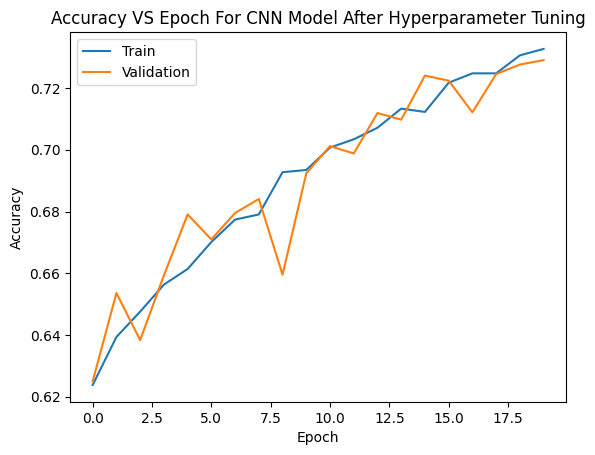

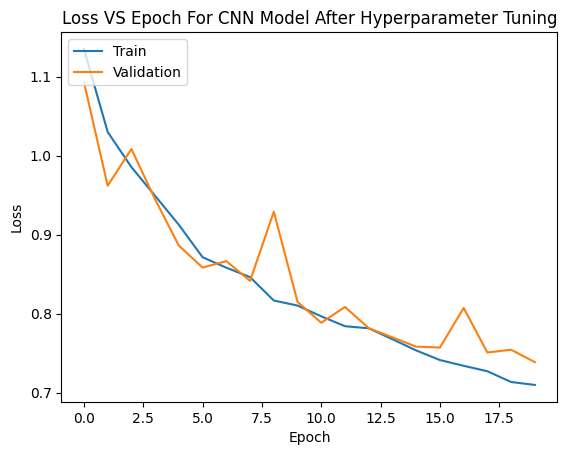

In [ ]:

plt.plot(cnn_best.history['accuracy'])
plt.plot(cnn_best.history['val_accuracy'])
plt.title('Accuracy VS Epoch For CNN Model After Hyperparameter Tuning')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

plt.plot(cnn_best.history['loss'])
plt.plot(cnn_best.history['val_loss'])
plt.title('Loss VS Epoch For CNN Model After Hyperparameter Tuning')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Summary Table With Hyperparameter Tuning


In [ ]:

from tabulate import tabulate

cnn1_table = [0.6989, 0.8007, 0.6995, 0.7806]
cnn2_table = [0.7080, 0.7736, 0.4610, 1.2804]
VGG16_table = [0.6625, 0.9433, 0.6507, 0.9441]
CNN1_best_table = [0.7353, 0.7026, 0.7290, 0.7385]

data = [
    ['CNN 1'] + cnn1_table,
    ['CNN 2'] + cnn2_table,
    ['VGG16'] + VGG16_table,
    ['CNN 1 (After Hyperparameter Tuning)'] + CNN1_best_table


]

headers = ['Models', 'Train data Accuracy', 'Train data Loss', 'Validation data Accuracy', 'Validation data Loss']

table = tabulate(data, headers=headers, tablefmt='grid')

print(table)

+-------------------------------------+-----------------------+-------------------+----------------------------+------------------------+
| Models                              |   Train data Accuracy |   Train data Loss |   Validation data Accuracy |   Validation data Loss |
+=====================================+=======================+===================+============================+========================+
| CNN 1                               |                0.6989 |            0.8007 |                     0.6995 |                 0.7806 |
+-------------------------------------+-----------------------+-------------------+----------------------------+------------------------+
| CNN 2                               |                0.708  |            0.7736 |                     0.461  |                 1.2804 |
+-------------------------------------+-----------------------+-------------------+----------------------------+------------------------+
| VGG16                           

# 1. Analysis:

From the summary table and accuracy and loss plots, we can see that VGG16 has the highest loss and lowest accuracy.

CNN Model 2 with swish activation has a slightly better accuracy compared with CNN Model 1. But it suffers from overfitting issues.

CNN Model 1 with relu activation has a much better validation accuracy than CNN Model 2. The validation accuracy is higher than the training accuracy.  

Why does CNN outperform VGG16 models?

VGG16 is a deeper model compared with the four-layer CNN model. It also supports transfer learning which helps fine-tune the model based on the dataset and reduce the computation cost.

But the class is imbalanced and the dataset is too small. VGG16 will cause the model to overfit. We are allowed to customize the CNN model based on the Cassava Leaf Disease dataset. It helps the CNN model capture more underlying features than the VGG16 model. Therefore better performance with the CNN model.

Why balance class weight won't work?

I have also tried to compute the class weight and balance it. But it makes the result worse. Because of the class distribution sensitivity and majority of the data are class 3 CMD disease. After balancing the class weight. The dataset loses a lot of information and makes the result worse.


# 2. Hyperparameter tuning summary:

CNN Model 1: Validation accuracy is higher than training accuracy.

CNN Model 2: Slightly better accuracy than CNN Model 1, but suffers from an overfitting issue.

VGG16 : Lowest accuracy and highest loss

This project is evaluated on validation accuracy. So I choose CNN Model 1 with relu activation for hyperparameter tuning.


Pre-defined hyperparameter tuning rangs:

dense units from 256 to 1024.
dropout rate from 0.2 to 0.5
learning rates from 1e-4 to 1e-1.
I used the Keras tuner with the random search for hyperparameter tuning because it randomly picks parameters which will help prevent overfitting, less computation cost and can potentially explore more broadly hyperparameters value.

The result show:

Best hyperparameters for CNN model 1 are:

256 units in the dense layer.

0.3 dropout rate.

0.001389 learning rate for the optimizer.

After retrain the model with the best parameters. The performance of the model has increased significantly. Please see the summary table.






In [ ]:

# Submission

test_datagen = ImageDataGenerator(rescale=1.0/255.0)

test_df = pd.DataFrame(os.listdir(test_dir), columns=['image_id'])


test_generator = test_datagen.flow_from_dataframe(
    dataframe=test_df,
    directory=test_dir,
    x_col='image_id',
    target_size=(image_size, image_size),
    batch_size=batch_size,
    class_mode=None,
    shuffle = False
)

pred = cnn_model_best.predict(test_generator)
predicted_labels = np.argmax(pred, axis=1)

submission_df = pd.DataFrame({
    'image_id': test_generator.filenames,
    'label': predicted_labels
})

submission_df.to_csv('submission.csv', index=False)


Found 1 validated image filenames.


/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 457ms/step


# Conclusion:

After performing hyperparameter tuning using the random search tuner, the performance of the CNN model improved significantly. The training, and validation data accuracy increased. The loss decreased.

# Learning and Takeaways:


CNN Model with Relu Activation works well for small datasets and low computational cost.

CNN Model with Swish Activation has a smooth gradient flow. It works well with deep networks and it works better with batch normalizations.

CNN model is good for beginning, it is simple and can be customizable based on the dataset. It works well with small and imbalanced datasets. It can capture more underlying features than the complex model.

VGG16 model supports transfer learning and works well with deep networks and complex datasets. It is too complex for a simple dataset. It will make the model overfitting.

When the dataset is small and imbalanced, simple model works better than complex model.

Keras tuner with the random search is great for hyperparameter tuning for deep learning. It picks parameters randomly within the parameter range. Which potentially has more options than grid search and reduces the computation cost.

# Improvements:

 I see others who use the EfficiNetB0 model get a much better result. Due to the limitation of the time, I could not try with that model. I would like to run the model and study why the EfficiNetB0 model works better than the VGG16 and ResNet50 models.  

 I would also like to have more data, so I can increase the model's accuracy and help farmers identify diseases.

# Reference:

1. Maksymshkliarevskyi. (2020, December 8). Cassava Leaf Disease: Best keras CNN. Kaggle. https://www.kaggle.com/code/maksymshkliarevskyi/cassava-leaf-disease-best-keras-cnn

2. Maksymshkliarevskyi. (2020b, December 20). Cassava Leaf Disease: Keras CNN baseline. Kaggle. https://www.kaggle.com/code/maksymshkliarevskyi/cassava-leaf-disease-keras-cnn-baseline

3. Ihelon. (2020, November 28). Cassava Leaf Disease - Exploratory Data analysis. Kaggle. https://www.kaggle.com/code/ihelon/cassava-leaf-disease-exploratory-data-analysis

4. Jessemostipak. (2020, December 5). Getting started: TPUs + Cassava Leaf Disease. Kaggle. https://www.kaggle.com/code/jessemostipak/getting-started-tpus-cassava-leaf-disease

5. XieXiao. (n.d.). 5511_-Cancer-Detection-Using-Deep-Learning/Cancer_Detection_Using_Deep_Learning_assignment_3.ipynb at main · XieXiao94/5511_-Cancer-Detection-Using-Deep-Learning. GitHub. https://github.com/XieXiao94/5511_-Cancer-Detection-Using-Deep-Learning/blob/main/Cancer_Detection_Using_Deep_Learning_assignment_3.ipynb

  This reference (number 5) is my assignment for week 3. Week 3 assignment is focused on binary image classification on histopathologic cancer dataset. My final project is a multi-class classification of the cassava leaf disease dataset. I have utilized the data augmentation, VGG16 model and CNN model 1 code from my week 3 assignment.